**Menghubungkan Directory Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Play and Plot Heart Sound**

In [2]:
import warnings                        # To ignore any warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%pylab inline
import os
import pandas as pd
import librosa
import librosa.display
import glob 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [3]:
# gather software versions
import tensorflow; print('tensorflow version: ', tensorflow.__version__)
import keras; print('keras version: ',keras.__version__)

tensorflow version:  2.6.0
keras version:  2.6.0


In [6]:
# heart it
import IPython.display as ipd
normal_sound = "drive/MyDrive/LKIR_LIPI/data/train/Atraining_normal/201108011118.wav"
murmur_sound = "drive/MyDrive/LKIR_LIPI/data/train/Atraining_murmur/201108222258.wav"
extrahls_sound = "drive/MyDrive/LKIR_LIPI/data/train/Atraining_extrahls/201104270459.wav"
artifact_sound = "drive/MyDrive/LKIR_LIPI/data/train/Atraining_artifact/201106221254.wav"

<class 'str'>


In [ ]:
# play normal
ipd.Audio(normal_sound)

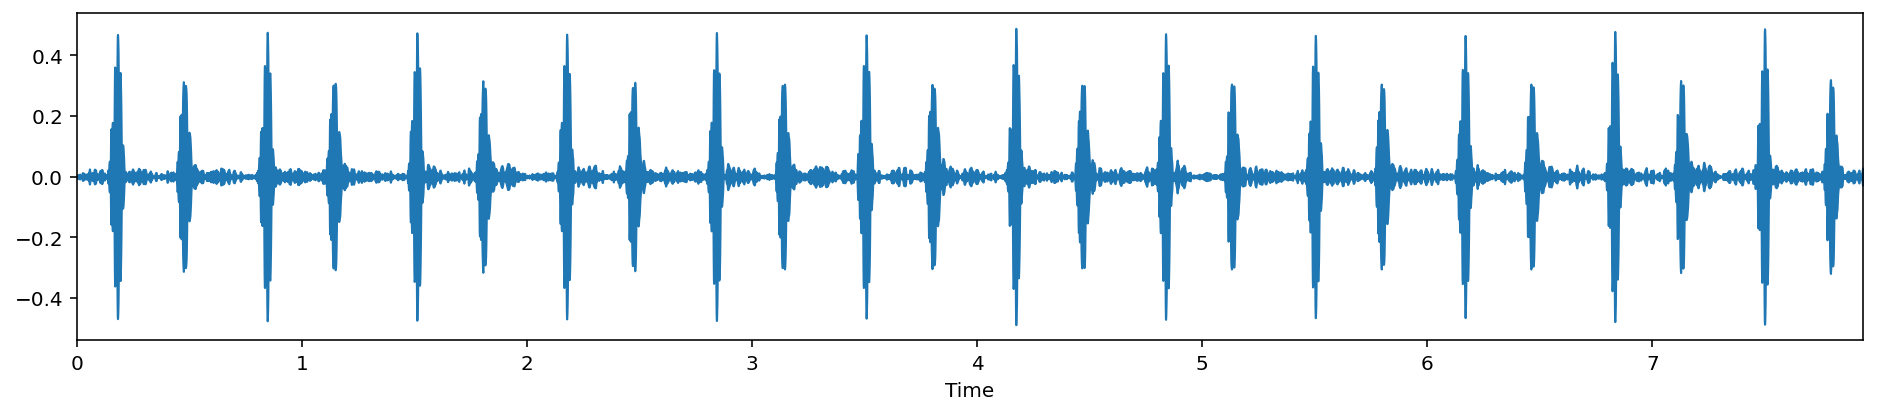

In [ ]:
# plot normal
y, sr = librosa.load(normal_sound)
plt.figure(figsize=(16, 3))
librosa.display.waveplot(y, sr=sr)

In [ ]:
# play murmur
ipd.Audio(murmur_sound)

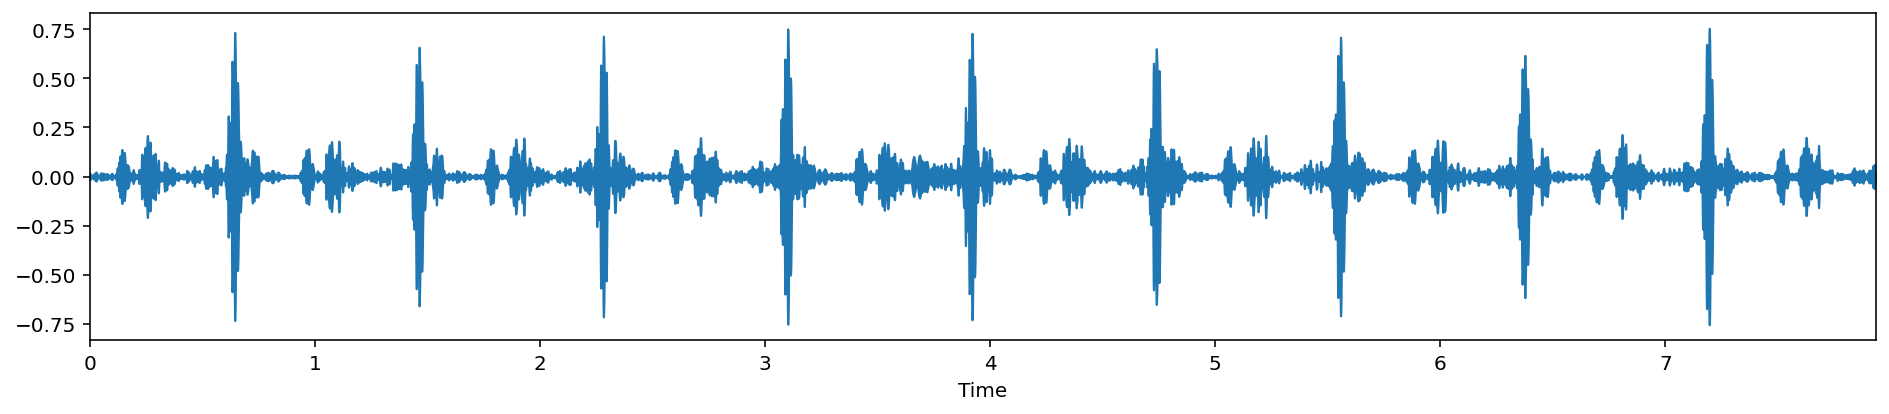

In [ ]:
# plot murmur
y, sr = librosa.load(murmur_sound)
plt.figure(figsize=(16, 3))
librosa.display.waveplot(y, sr=sr)

In [ ]:
# play extrahls
ipd.Audio(extrahls_sound)

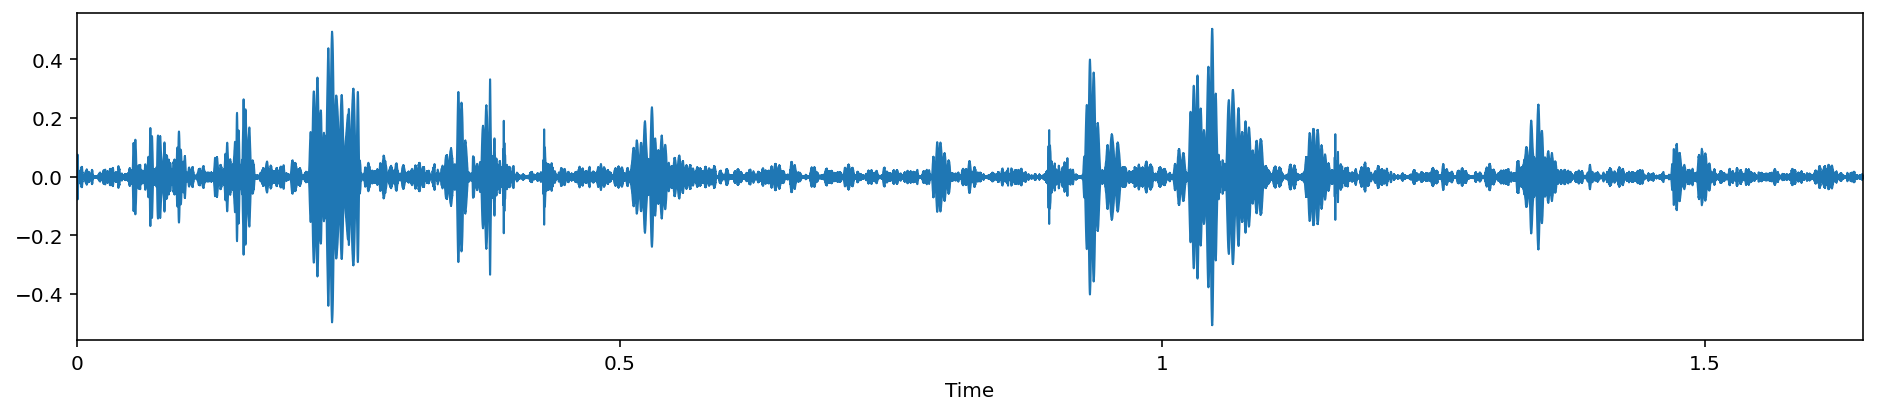

In [ ]:
# plot extrahals
y, sr = librosa.load(extrahls_sound)
plt.figure(figsize=(16, 3))
librosa.display.waveplot(y, sr=sr)

In [ ]:
# play artifact
# ipd.Audio(artifact_sound)

In [ ]:
# plot artifact
# y, sr = librosa.load(artifact_sound)
# plt.figure(figsize=(16, 3))
# librosa.display.waveplot(y, sr=sr)

**Ekstraksi Fitur Suara dengan MFCC**

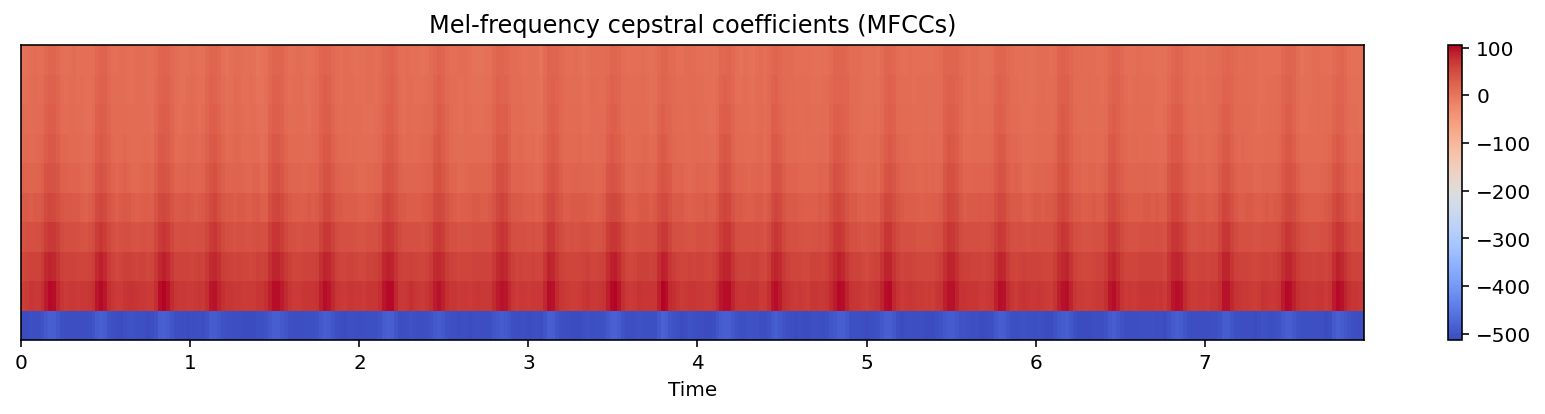

In [ ]:
# Get more components
y, sr = librosa.load(normal_sound)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=10)
# Visualize the MFCC series
# Mel-frequency cepstral coefficients (MFCCs)
plt.figure(figsize=(12, 3))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('Mel-frequency cepstral coefficients (MFCCs)')
plt.tight_layout()

**Preprocessing Data Train**

In [ ]:
def get_labels(path):
  labels = os.listdir(path)
  return labels

def wav2mfcc(file_path, duration=5, sr=22050):
  X, sr = librosa.load(file_path, sr=sr, duration=duration,res_type='kaiser_fast') 
  dur = librosa.get_duration(y=X, sr=sr)
  y = X
  while (dur<duration):
    y = np.append(y,y)
    dur = librosa.get_duration(y=y, sr=sr)
  if (dur >= duration):
    sound = y[0:duration*sr] 
  mfcc = librosa.feature.mfcc(sound, sr=22050,n_mfcc=15)
  return mfcc

def save_data_to_array(path):
  labels = get_labels(path)
  for label in labels:
    mfcc_vectors = []
    wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir (path + '/' + label)]
    for wavfile in wavfiles:
      mfcc = wav2mfcc(wavfile)
      mfcc_vectors.append(mfcc)
    np.save(label + '.npy', mfcc_vectors)

def get_train_test(path, split_ratio=0.80):
  labels = get_labels(path)
  lab = np.ones(len(labels))
  label_all = np.diag(lab)
  X = np.load(labels[0] + '.npy')
  Y = label_all[0]
  for i in range(len(X)-1):
    Y = np.vstack((Y, label_all[0]))
  for label in labels[1:]:
    x = np.load(label + '.npy')
    X = np.vstack((X, x))
    for i in range(len(x)):
      Y = np.vstack((Y,label_all[labels.index(label)]))
  assert X.shape[0] == len(Y)
  return train_test_split(X, Y, test_size = (1-split_ratio), shuffle=True)

data_path = "drive/MyDrive/LKIR_LIPI/data/train/"
save_data_to_array(data_path)
x_train,x_test,y_train,y_test = get_train_test(data_path,split_ratio=0.75)

# normalisasi
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(93, 15, 216)
(31, 15, 216)
(93, 4)
(31, 4)


**Rancangan Arsitektur Model LSTM**

In [ ]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools

print('Build LSTM RNN model ...')
model = Sequential()

model.add(LSTM(560,input_shape = (x_train.shape[1],x_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(360, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(240, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='sigmoid'))
model.summary()

# model.add(LSTM(units=240, dropout=0.25, recurrent_dropout=0.3, return_sequences=True,input_shape = (x_train.shape[1],x_train.shape[2])))
# model.add(LSTM(units=120, dropout=0.25, recurrent_dropout=0.3, return_sequences=True))
# model.add(LSTM(units=30, dropout=0.25, recurrent_dropout=0.3, return_sequences=False))
# model.add(Dense(y_train.shape[1], activation='softmax'))
# model.summary()

# print('Build CNN model ...')
# model = Sequential()
# model.add(Conv2D(32, (2, 2), activation='relu',input_shape = (x_train.shape[1],x_train.shape[2],1)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))
# # model.add(Conv2D(64, (2, 2), activation='relu'))
# # model.add(MaxPooling2D(pool_size=(2, 2)))
# # model.add(Dropout(0.2))
# # Classifier
# model.add(Flatten())
# model.add(Dense(1080, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(720, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(480, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(240, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(y_train.shape[1], activation='softmax'))
# model.summary()
# x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
# x_test=x_test.reshape(x_test.shape[0],x_train.shape[1],x_train.shape[2],1)

Build LSTM RNN model ...
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 560)               1740480   
_________________________________________________________________
dropout_36 (Dropout)         (None, 560)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 360)               201960    
_________________________________________________________________
dropout_37 (Dropout)         (None, 360)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 240)               86640     
_________________________________________________________________
dropout_38 (Dropout)         (None, 240)               0         
_________________________________________________________________
dense_38 (Dense)             

**Train dan Save Model**

In [ ]:
# %%time
# # saved model checkpoint file
# best_model_file="./model_heartsound.hdf5"
# MAX_PATIENT=12
# MAX_EPOCHS=250
# MAX_BATCH=32
# model.compile(loss='categorical_crossentropy',optimizer=tensorflow.keras.optimizers.Adam(lr=0.0000001),metrics=['accuracy'])
# # callbacks
# # removed EarlyStopping(patience=MAX_PATIENT)
# callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
#           ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

# print ("training started..... please wait.")
# # training
# history=model.fit(x_train, y_train, 
#                   batch_size=MAX_BATCH, 
#                   epochs=MAX_EPOCHS,
#                   verbose=0,
#                   validation_data=(x_test, y_test),
#                   callbacks=callback) 

# print ("training finised!")

%%time
model.compile(loss='categorical_crossentropy',optimizer=tensorflow.keras.optimizers.Adam(lr=0.0000025),metrics=['accuracy'])
history = model.fit(x_train, y_train,batch_size=31,epochs=5000,verbose=1,validation_data=(x_test, y_test))
model.save('./model_heartsound.hdf5')
print ("training finised!")

Streaming output truncated to the last 5000 lines.
3/3 [==============================] - 1s 264ms/step - loss: 0.1970 - accuracy: 1.0000 - val_loss: 0.9257 - val_accuracy: 0.6774
Epoch 2503/5000
3/3 [==============================] - 1s 274ms/step - loss: 0.2217 - accuracy: 0.9892 - val_loss: 0.9251 - val_accuracy: 0.6774
Epoch 2504/5000
3/3 [==============================] - 1s 298ms/step - loss: 0.2409 - accuracy: 1.0000 - val_loss: 0.9251 - val_accuracy: 0.6774
Epoch 2505/5000
3/3 [==============================] - 1s 278ms/step - loss: 0.1863 - accuracy: 1.0000 - val_loss: 0.9250 - val_accuracy: 0.6774
Epoch 2506/5000
3/3 [==============================] - 1s 277ms/step - loss: 0.1989 - accuracy: 1.0000 - val_loss: 0.9246 - val_accuracy: 0.6774
Epoch 2507/5000
3/3 [==============================] - 1s 280ms/step - loss: 0.1953 - accuracy: 1.0000 - val_loss: 0.9247 - val_accuracy: 0.6774
Epoch 2508/5000
3/3 [==============================] - 1s 283ms/step - loss: 0.1974 - accuracy:

In [ ]:
# Keras reported accuracy:
score = model.evaluate(x_train, y_train, verbose=0) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(x_test, y_test, verbose=0) 
print ("model test data score        : ",round(score[1]*100) , "%")

model train data score       :  100 %
model test data score        :  71 %


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


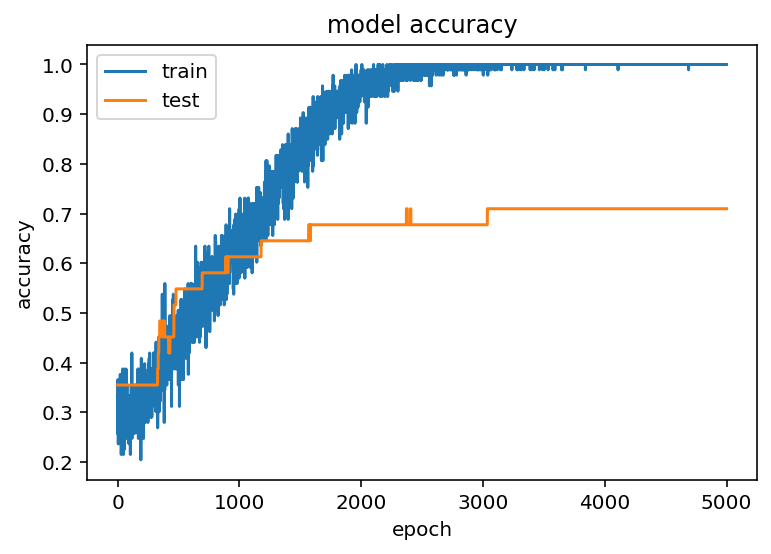

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

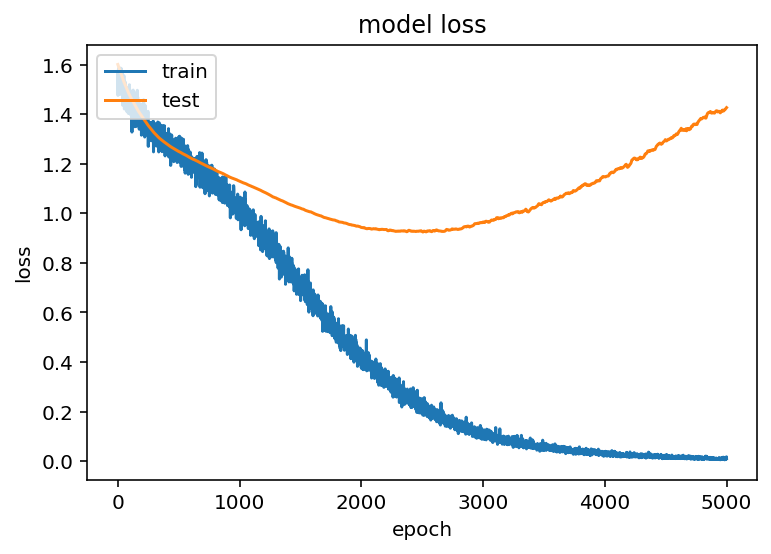

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Load dan Predict Model Hasil Train**

['Atraining_artifact', 'Atraining_murmur', 'Atraining_normal', 'Atraining_extrahls']
[[0.32698235 0.9884087  0.238913   0.0665215 ]]
Result : Atraining_murmur


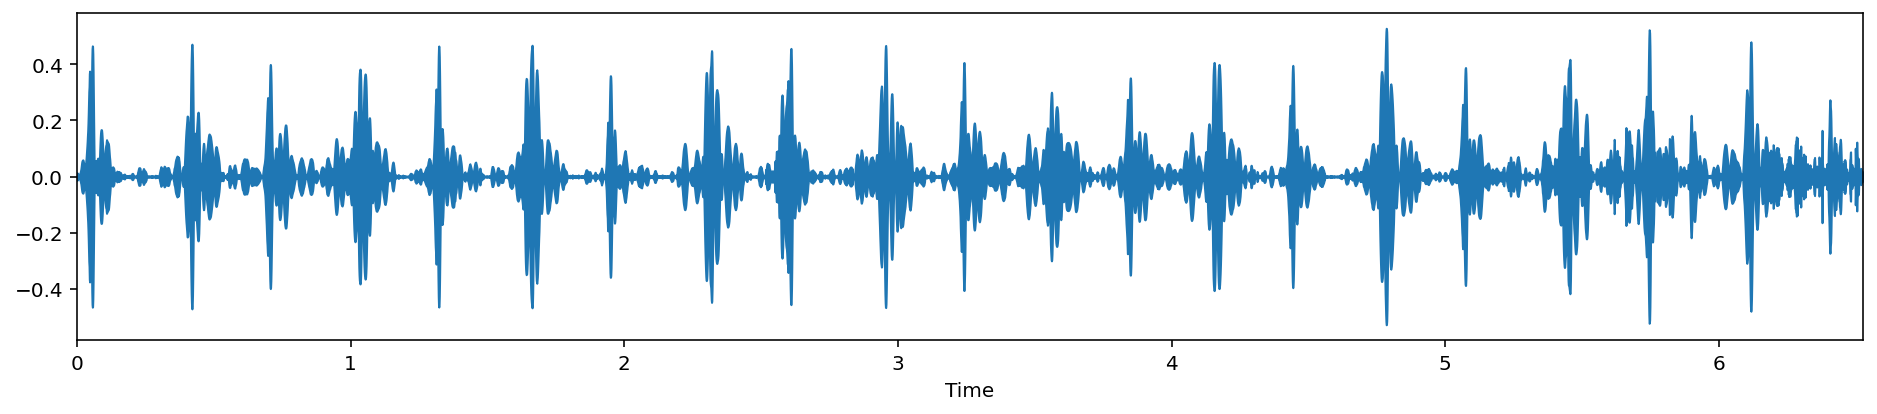

In [ ]:
from keras.models import load_model

model_sound = load_model('./model_heartsound.hdf5')
kelas = get_labels("drive/MyDrive/LKIR_LIPI/data/train/")
print(kelas)

file = "drive/MyDrive/LKIR_LIPI/data/test/Aunlabelledtest/201106211725.wav"
# file = "drive/MyDrive/LKIR_LIPI/data/train/Atraining_normal/201108011112.wav"
# file = normal_sound
tes = wav2mfcc(file)

result = model.predict(tes.reshape(1,tes.shape[0],tes.shape[1]))
# result = model.predict(tes.reshape(1,tes.shape[0],tes.shape[1],1))
print(result)
print("Result :", kelas[np.argmax(result)])

# plot file
y, sr = librosa.load(file)
plt.figure(figsize=(16, 3))
librosa.display.waveplot(y, sr=sr)